In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

# Baseline

In [2]:
# Training settings
batch_size = 64

# MNIST Dataset
train_dataset = datasets.MNIST(root='./data/',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='./data/',
                              train=False,
                              transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [3]:
train_dataset[0][0].size()

torch.Size([1, 28, 28])

In [16]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size = 5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size = 5)
    self.mp = nn.MaxPool2d(2)
    self.fc = nn.Linear(320, 10) ### : 알맞는 input은? 20*4*4

  def forward(self, x):
    in_size = x.size(0)
    x = F.relu(self.mp(self.conv1(x))) # 28->24->12
    x = F.relu(self.mp(self.conv2(x))) # 12->8->4
    x = x.view(in_size, -1)
    x = self.fc(x)
    return F.log_softmax(x)

In [17]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)

In [18]:
def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = Variable(data), Variable(target)
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 10 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))

In [19]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data # nll_loss?? / cross entropy loss와의 관계 확인!
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
for epoch in range(1, 10):
    train(epoch)
    test()
# Average loss: 0.0458, Accuracy: 9848/10000 (98%)

## Task 1 : 
위 베이스라인 구조를 아래와 같은 형태로 변경 + MNIST 데이터셋 (위 베이스라인에서 사용한 데이터셋)

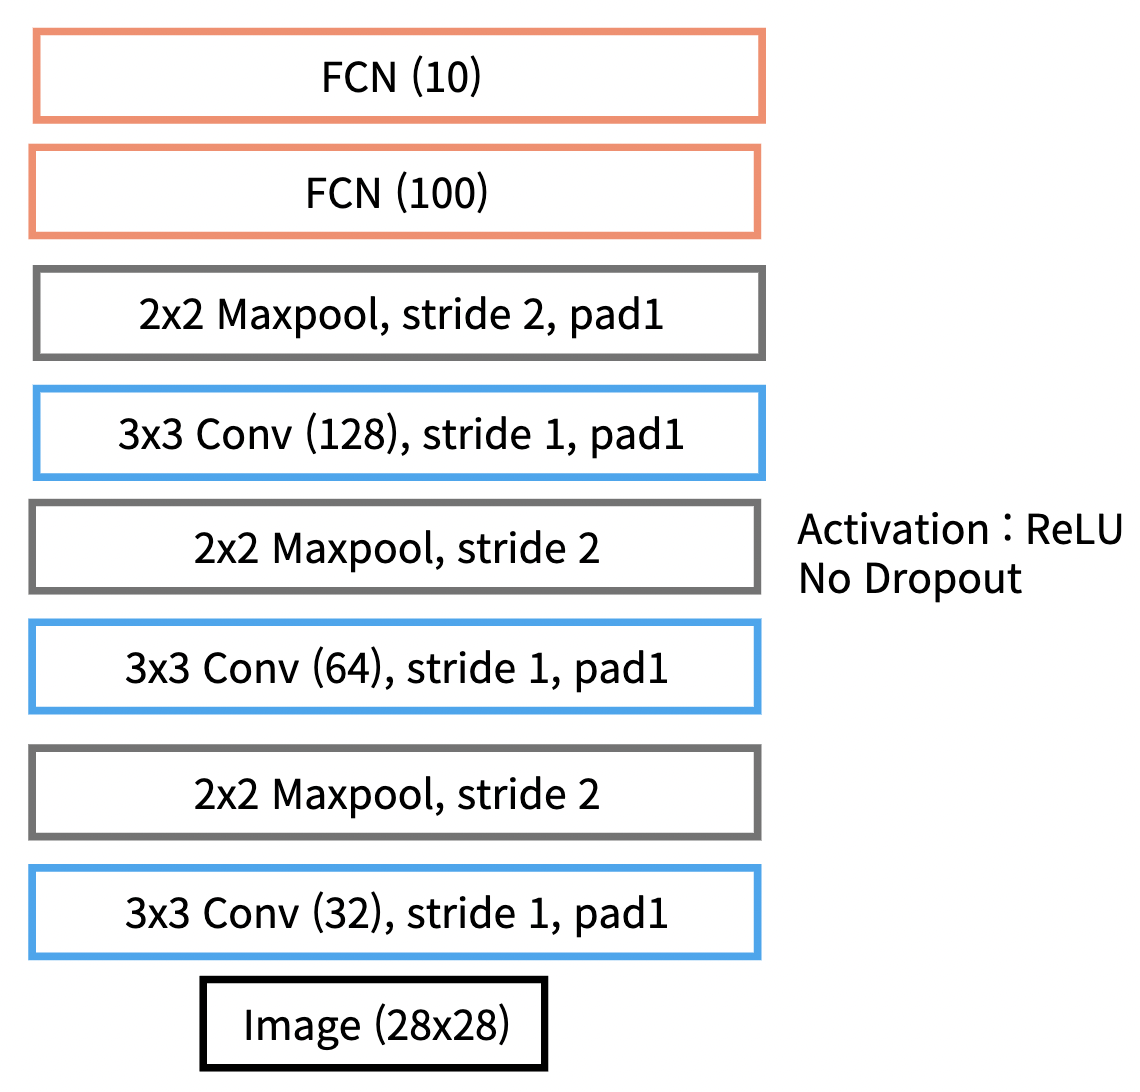

In [17]:
class revised_Net(nn.Module):
  def __init__(self):
    super(revised_Net, self).__init__()
    ###
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, stride=1, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, stride=1, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, stride=1, kernel_size=3, padding=1)
    ###
    self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
    ###
    self.fc1 = nn.Linear(2048, 100) # 128*4*4
    self.fc2 = nn.Linear(100, 10)
    
  def forward(self, x):
    in_size = x.size(0)
    ###
    x = F.relu(self.mp1(self.conv1(x))) # 28->13
    x = F.relu(self.mp1(self.conv2(x))) # 13->7
    x = F.relu(self.mp2(self.conv3(x))) # 7->4
    x = x.view(in_size, -1)
    x = self.fc1(x)
    x = self.fc2(x)
    return F.log_softmax(x)

In [18]:
model = revised_Net()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)

def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = Variable(data), Variable(target)
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 10 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))
      
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data # nll_loss?? / cross entropy loss와의 관계 확인!
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
for epoch in range(1, 10):
    train(epoch)
    test()
# Test set: Average loss: 0.0616, Accuracy: 9797/10000 (98%)

# Task 2 : 
베이스라인 마음대로 변경 + Softmax regression 과제에서  사용했던 데이터셋 (변경 가능하나 같은 데이터셋으로 진행하시는 걸 추천드립니다!) >> CNN으로 성공해보자!

* 지난번 과제와 마찬가지로 다양한 방식을 시도해보시고 그 시도 기록을 남겨주세요. 가장 성능이 좋았던 모델도 표시 부탁드립니다!

* 이번엔 GPU resource 문제가 생길 수 있습니다. 파라미터 조정, dropout 추가 등 연산 효율성도 고려해서 베이스라인 조정해보세요!

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
import torch
import torchvision
import torchvision.transforms as transforms # 데이터 전처리를 위해 사용되는 패키지
# import torchvision.models as models # 파이토치 네트워크를 사용할 수 있도록 도와주는 패키지
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
import torch.nn.functional as F

# from d2l import torch as d2l
import matplotlib.pyplot as plt
import numpy as np
import string
from sklearn.metrics import accuracy_score

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

In [113]:
data_path_train = '/content/drive/MyDrive/Colab Notebooks/Pytorch스터디/DATA/catanddog/train'
data_path_test = '/content/drive/MyDrive/Colab Notebooks/Pytorch스터디/DATA/catanddog/test'
batch_size=16

def dataloader_func(path, batch_size):
  transform = transforms.Compose([transforms.Resize([64,64]), # 합성곱층을 통과하기 위해 이미지 크기를 조정
                                transforms.ToTensor()]) # 이미지 데이터를 텐서로 변환
  dataset = torchvision.datasets.ImageFolder(data_path_train, transform=transform)
  loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=8) # 하위 프로세스를 몇개 사용할지 설정
  return dataset, loader

train_dataset, train_loader = dataloader_func(data_path_train, batch_size)
test_dataset, test_loader = dataloader_func(data_path_test, batch_size)

In [114]:
print(len(train_dataset)) # dataset 길이 : 385
print(train_dataset[0][0].size())
print(samples.shape) # batch_size * depht * width * height

(124800, 20800)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


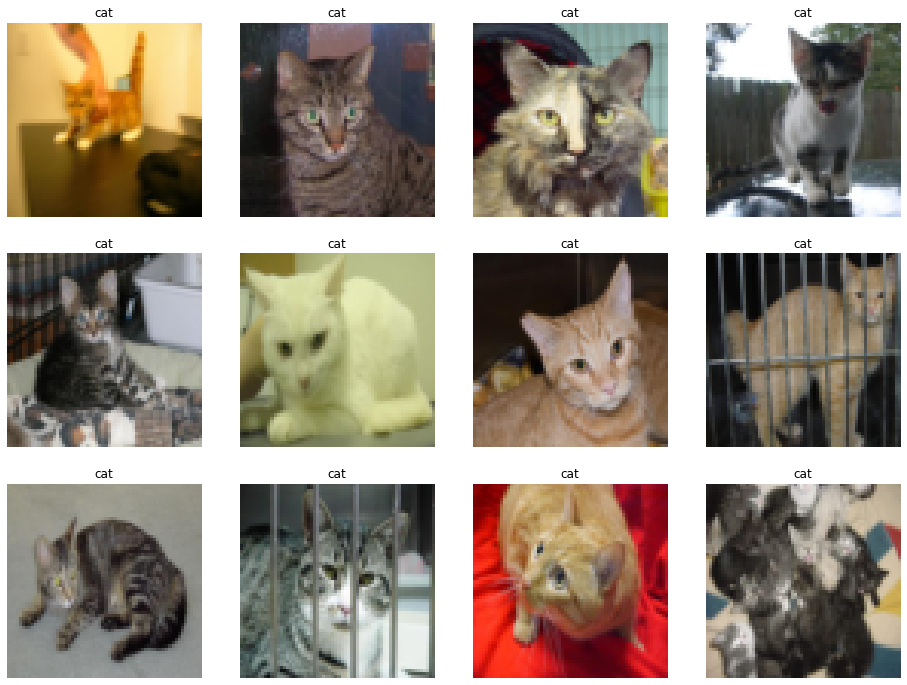

In [92]:
data, target = iter(train_loader).next()
classes = {0:'cat',1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(12):
  a = fig.add_subplot(3,4,i+1)
  a.set_title(classes[target[i].item()])
  a.axis('off')
  a.imshow(np.transpose(data[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [173]:
class CatNDog(nn.Module):
  def __init__(self):
    super(CatNDog, self).__init__()
    ###
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, stride=1, kernel_size=3)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, stride=1, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, stride=1, kernel_size=3, padding=1)
    ###
    self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
    ###
    self.fc1 = nn.Linear(8192, 256) # 128*8*8
    self.fc2 = nn.Linear(256, 2)
    ###
    self.do = nn.Dropout(0.3)
    
  def forward(self, x):
    in_size = x.size(0)
    ###
    x = F.relu(self.mp1(self.conv1(x)))
    x = F.relu(self.mp1(self.conv2(x)))
    x = F.relu(self.mp1(self.conv3(x)))
    x = x.view(in_size, -1)
    x = self.do(self.fc1(x))
    x = self.fc2(x)
    return F.log_softmax(x)

In [174]:
def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = Variable(data), Variable(target)
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 3 == 0:
      print('Epoch: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))

def test(epoch):
    model.eval()
    testloss_lst = []
    test_loss = 0
    corrects = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data # nll_loss?? / cross entropy loss와의 관계 확인!
        _, preds = torch.max(output.data,1)
        preds[preds >= 0.5] = 1
        preds[preds < 0.5] = 0
        corrects += preds.eq(target.cpu()).int().sum()

    test_loss /= len(test_loader.dataset)
    acc = 100. * corrects / len(test_loader.dataset)

    loss_lst.append(test_loss)
    acc_lst.append(acc)

    print(f'{epoch}th Epoch result', end=' ')
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, corrects, len(test_loader.dataset), acc))

In [243]:
model = CatNDog()
optimizer = optim.Adam(model.parameters(), lr = 0.00001)
loss_lst = []
acc_lst = []
# learning_rate=0.0001, conv_layer=3, linear_layer=2
for epoch in range(1, 10):
    train(epoch)
    test(epoch)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: [0/385 (0%)]	Loss: 0.670279
Epoch: [48/385 (12%)]	Loss: 0.626721
Epoch: [96/385 (24%)]	Loss: 0.572322
Epoch: [144/385 (36%)]	Loss: 0.528477
Epoch: [192/385 (48%)]	Loss: 0.963516
Epoch: [240/385 (60%)]	Loss: 0.995862
Epoch: [288/385 (72%)]	Loss: 0.939175
Epoch: [336/385 (84%)]	Loss: 0.899841
Epoch: [24/385 (96%)]	Loss: 0.889404


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


1th Epoch result 
Test set: Average loss: 0.7117, Accuracy: 182/385 (47.27%)

Epoch: [0/385 (0%)]	Loss: 0.565141
Epoch: [48/385 (12%)]	Loss: 0.589246
Epoch: [96/385 (24%)]	Loss: 0.590454
Epoch: [144/385 (36%)]	Loss: 0.587540
Epoch: [192/385 (48%)]	Loss: 0.831899
Epoch: [240/385 (60%)]	Loss: 0.833652
Epoch: [288/385 (72%)]	Loss: 0.809060
Epoch: [336/385 (84%)]	Loss: 0.775640
Epoch: [24/385 (96%)]	Loss: 0.767804
2th Epoch result 
Test set: Average loss: 0.6967, Accuracy: 182/385 (47.27%)

Epoch: [0/385 (0%)]	Loss: 0.645670
Epoch: [48/385 (12%)]	Loss: 0.663195
Epoch: [96/385 (24%)]	Loss: 0.668251
Epoch: [144/385 (36%)]	Loss: 0.664077
Epoch: [192/385 (48%)]	Loss: 0.743553
Epoch: [240/385 (60%)]	Loss: 0.744441
Epoch: [288/385 (72%)]	Loss: 0.732580
Epoch: [336/385 (84%)]	Loss: 0.716775
Epoch: [24/385 (96%)]	Loss: 0.669846
3th Epoch result 
Test set: Average loss: 0.6918, Accuracy: 205/385 (53.25%)

Epoch: [0/385 (0%)]	Loss: 0.695172
Epoch: [48/385 (12%)]	Loss: 0.714836
Epoch: [96/385 (24%)]	

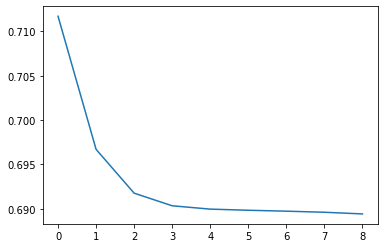

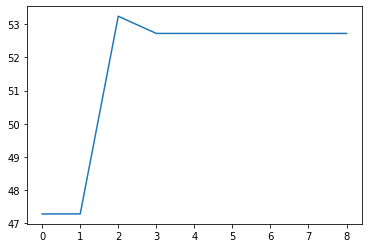

In [245]:
import matplotlib.pyplot as plt

plt.plot(np.arange(9),loss_lst)
plt.show()
plt.plot(np.arange(9),acc_lst)
plt.show()

In [197]:
# class CatNDog2(nn.Module):
#   def __init__(self):
#     super(CatNDog2, self).__init__()
#     ###
#     self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, stride=1, kernel_size=3)
#     self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, stride=1, kernel_size=3, padding=1)
#     self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, stride=1, kernel_size=3, padding=1)
#     self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, stride=1, kernel_size=3, padding=1)
#     self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, stride=1, kernel_size=3, padding=1)
#     self.conv6 = nn.Conv2d(in_channels=256, out_channels=128, stride=1, kernel_size=3, padding=1)
#     ###
#     self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2)
#     self.mp2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
#     ###
#     self.fc1 = nn.Linear(2048, 256)
#     self.fc2 = nn.Linear(256, 128)
#     self.fc3 = nn.Linear(128, 64)
#     self.fc4 = nn.Linear(64, 16)
#     self.fc5 = nn.Linear(16, 2)
#     ###
#     self.do = nn.Dropout(0.3)
    
#   def forward(self, x):
#     in_size = x.size(0)
#     ###
#     x = F.relu(self.mp1(self.conv1(x)))
#     x = F.relu(self.conv2(x))
#     x = F.relu(self.conv3(x))
#     x = F.relu(self.mp2(self.conv4(x)))
#     x = F.relu(self.mp2(self.conv5(x)))
#     x = F.relu(self.mp2(self.conv6(x)))

#     x = x.view(in_size, -1)
#     x = self.do(self.fc1(x))
#     x = self.do(self.fc2(x))
#     x = self.fc3(x)
#     x = self.fc4(x)
#     x = self.fc5(x)
#     return F.log_softmax(x)

In [241]:
# model = CatNDog2()
# optimizer = optim.Adam(model.parameters(), lr = 0.00001)
# loss_lst = []
# acc_lst = []
# # learning_rate=0.0001, conv_layer=6, linear_layer=5 >> layer를 더 복잡하게
# for epoch in range(1, 10):
#     train(epoch)
#     test(epoch)

In [242]:
# plt.plot(np.arange(9),loss_lst)
# plt.show()

# plt.plot(np.arange(9),acc_lst)
# plt.show()